<a href="https://colab.research.google.com/github/TsungyuT/class_notebooks/blob/master/models/RetinaNet/RetinaNet_G13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

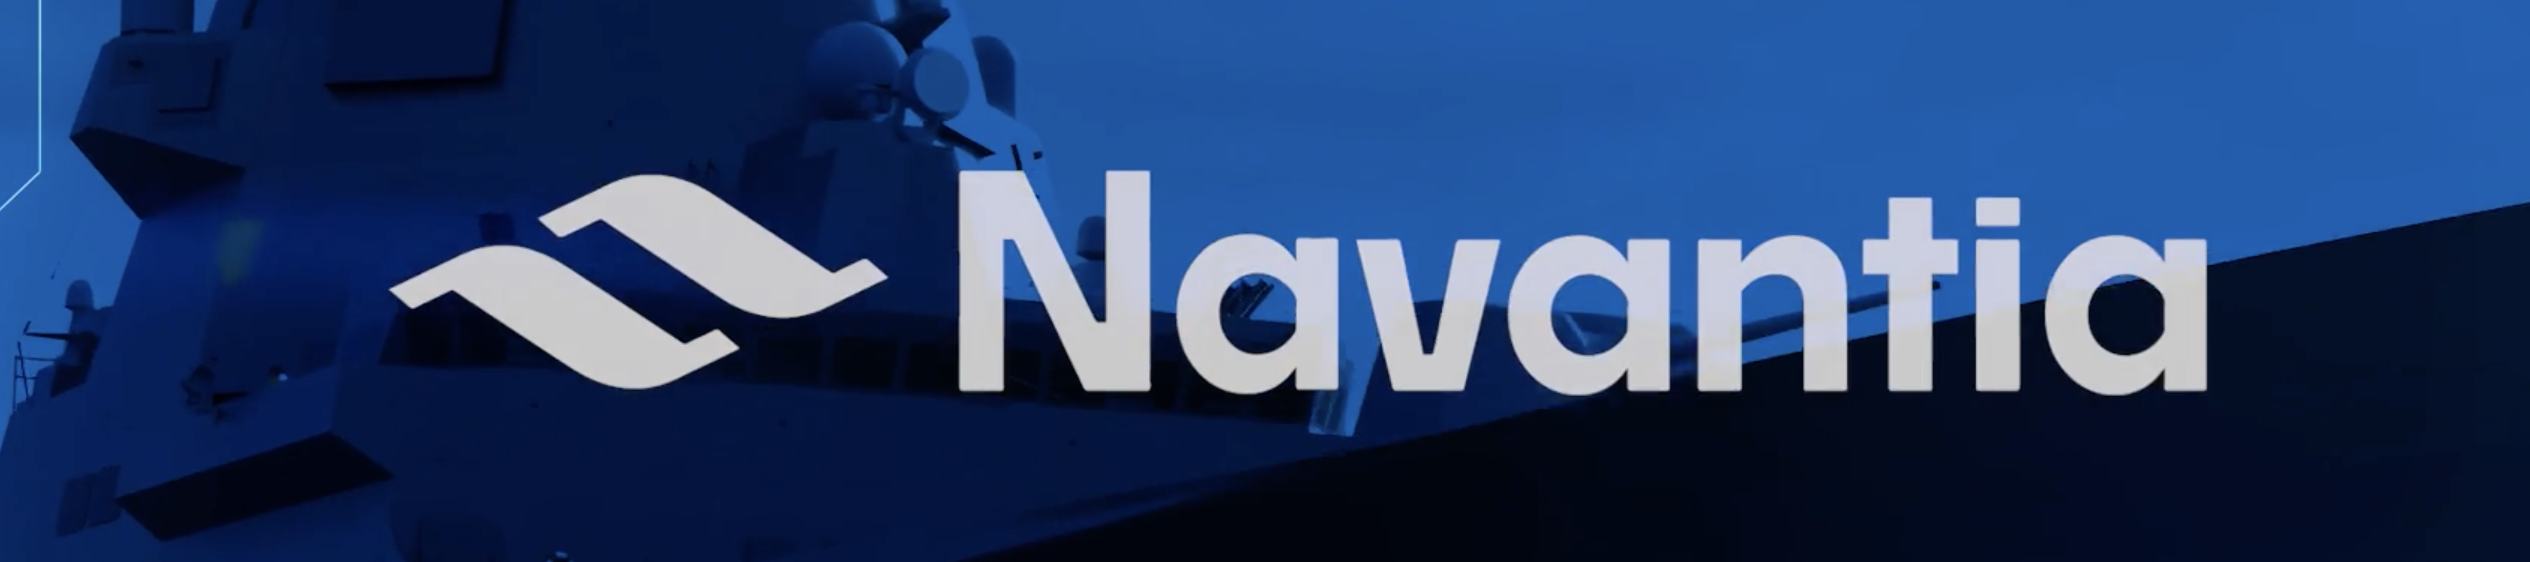

# **Introduction**

In this notebook, we implement PyTorch RetinaNet based on Mr.Ayushman Buragohain´s github reposotory (https://github.com/benihime91) for custom dataset. 

We will take the following steps to implement PyTorch RetinaNet on our custom data:
* Install PyTorch RetinaNet along with required dependencies.
* Download Custom Dataset.
* Write Training Configuation yaml file .
* Train  Detection Model .
* Use Trained PyTorch RetinaNet Object Detection For Inference on Test Images.


### **Setting up Colab :**

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# **Install Pytorch Retinanet and Dependencies** :

In [ ]:
!pip install -Uqq pytorch-lightning==1.0.0 omegaconf
!pip install -Uqq git+https://github.com/albumentations-team/albumentations
!pip uninstall torchtext
!git clone https://github.com/ANACERMIR/Capstone_Project_G13.git

  Preparing metadata (setup.py) ... done
fatal: destination path 'Capstone_Project_G13' already exists and is not an empty directory.


In [ ]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# **Prepare Pytorch Retinanet Object Detection Training Data**

We will use the **[BCCD Dataset](https://public.roboflow.com/object-detection/bccd)** from RoboFlow. There are 364 images across three classes.


To train on the custom dataset the data needs to be in either **csv** or **pascal-voc** format . Roboflow makes it easier to generate the datasets. We can directly download the datsets in required format.

We will download the dataset in **Pascal-VOC** format and then use in-built methods available in PyTorch Retinanet to convert our data into **csv** format.

In [ ]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content
#!curl -L "https://app.roboflow.com/ds/xxxxxxxxxxxxxxxx" > roboflow.zip; unzip -qq roboflow.zip; rm roboflow.zip

/content


In [ ]:
#Set up paths 

#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/Capstone_Project_G13/dataset/train/images"
VALID_IMAGE_PATH = "/content/Capstone_Project_G13/dataset/valid/images"
TEST_IMAGE_PATH  = "/content/Capstone_Project_G13/dataset/test/images"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/content/Capstone_Project_G13/dataset/train/labels/PascalVoc"
VALID_ANNOT_PATH = "/content/Capstone_Project_G13/dataset/valid/labels/PascalVoc"
TEST_ANNOT_PATH  = "/content/Capstone_Project_G13/dataset/test/labels/PascalVoc"

In [ ]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np

from Capstone_Project_G13.models.RetinaNet.utils.pascal import convert_annotations_to_df

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

## **Generate csv file from XML Annotations:**

In [ ]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOT_PATH, VALID_IMAGE_PATH, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")


def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

### **CSV Files are as follows :**

In [ ]:
train_df['xmax'] = np.where(
    (train_df['xmax'] > train_df["width"]) , train_df["width"], train_df['xmax']
   )

In [ ]:
train_df['ymax'] = np.where(
    (train_df['ymax'] > train_df["height"]) , train_df["height"], train_df['ymax']
   )

In [ ]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/Capstone_Project_G13/dataset/train/images/img_03_0573_jpg.rf.2cf14300505e21027acf3f6baba8ea23.jpg,640,640,cruises,113,18,622,361,3
1,/content/Capstone_Project_G13/dataset/train/images/img_00_1247_jpg.rf.5c5959ef423ca9669e7f3941736a8381.jpg,640,640,submarine,1,62,640,433,5
2,/content/Capstone_Project_G13/dataset/train/images/img_03_1239_jpg.rf.0ef0a38def5a463df8a41e2a1f5f8ec9.jpg,640,640,cruises,30,188,617,444,3
3,/content/Capstone_Project_G13/dataset/train/images/img_02_0159_jpg.rf.a27594df98c468fce4f3b091947f0940.jpg,640,640,Fragata,38,226,640,638,1
4,/content/Capstone_Project_G13/dataset/train/images/img_02_0251_jpg.rf.0e9bb6224acff384bb494043a3f00f51.jpg,640,640,Fragata,3,129,635,493,1


In [ ]:
valid_df['ymax'] = np.where(
    (valid_df['ymax'] > valid_df["height"]) , valid_df["height"], valid_df['ymax']
   )

In [ ]:
valid_df['xmax'] = np.where(
    (valid_df['xmax'] > valid_df["width"]) , valid_df["width"], valid_df['xmax']
   )

In [ ]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/Capstone_Project_G13/dataset/valid/images/img_03_0706_jpg.rf.2da6e59c85c50af0ab179abda6b6ebff.jpg,640,640,cruises,51,50,607,561,3
1,/content/Capstone_Project_G13/dataset/valid/images/img_03_1174_jpg.rf.8c31f80b0734de9367220c22b905ab17.jpg,640,640,cruises,114,168,571,475,3
2,/content/Capstone_Project_G13/dataset/valid/images/img_00_0031_jpg.rf.060196093d764a7ff9c3689b1e10b689.jpg,640,640,submarine,48,5,609,548,5
3,/content/Capstone_Project_G13/dataset/valid/images/img_01_0968_jpg.rf.76d67d42b7825a09b6e322691c6799cf.jpg,640,640,Portanaves,34,258,619,431,2
4,/content/Capstone_Project_G13/dataset/valid/images/img_01_0618_jpg.rf.41763c6882720b927f2ca206479ba548.jpg,640,640,Portanaves,22,271,543,569,2


In [ ]:
test_df['ymax'] = np.where(
    (test_df['ymax'] > test_df["height"]) , test_df["height"], test_df['ymax']
   )

In [ ]:
test_df['xmax'] = np.where(
    (test_df['xmax'] > test_df["width"]) , test_df["width"], test_df['xmax']
   )

In [ ]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/Capstone_Project_G13/dataset/test/images/img_02_0125_jpg.rf.61d15c8e652db2dec61f04ea664e0a5e.jpg,640,640,Fragata,62,316,585,462,1
1,/content/Capstone_Project_G13/dataset/test/images/img_00_0264_jpg.rf.ad521bae2be73d1c99d3abb54a41c57f.jpg,640,640,submarine,35,285,605,417,5
2,/content/Capstone_Project_G13/dataset/test/images/img_02_0813_jpg.rf.cdcdcca73c34df51554427fb51d52d89.jpg,640,640,Fragata,159,2,581,574,1
3,/content/Capstone_Project_G13/dataset/test/images/img_03_0276_jpg.rf.ebe8c0d8ac5dec44f5c7c4d03a49c472.jpg,640,640,cruises,92,166,574,444,3
4,/content/Capstone_Project_G13/dataset/test/images/00000521_jpg.rf.f24570452ed60f487234f8a713c5ac2e.jpg,640,640,helicopter,71,207,573,457,4


In [ ]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV  = "/content/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

# **View Images from the Dataset** :

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

##**Let's now generate the Label Map which is used for visualization:**

In [ ]:
from Capstone_Project_G13.models.RetinaNet.utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__',
 'Fragata',
 'Portanaves',
 'cruises',
 'helicopter',
 'submarine',
 'tugboat']

##**Plot images with Bounding boxes over them**:

In [ ]:
from Capstone_Project_G13.models.RetinaNet.utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index

    Params
    ------
        dataframe : a pandas dataframe object
        index (int) : a integer corresponding to a index in the pandas dataframe

    Returns
    -------
        fname (str) : path to the selected image.
        bbbs (list) : a list containing the bounding box annotations for the `fname`.
        cls (list) : a list containing the integer class labels for the box annotations.  
    """
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values
    return fname, bbs, cls

def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

### **Image from Train Data:**

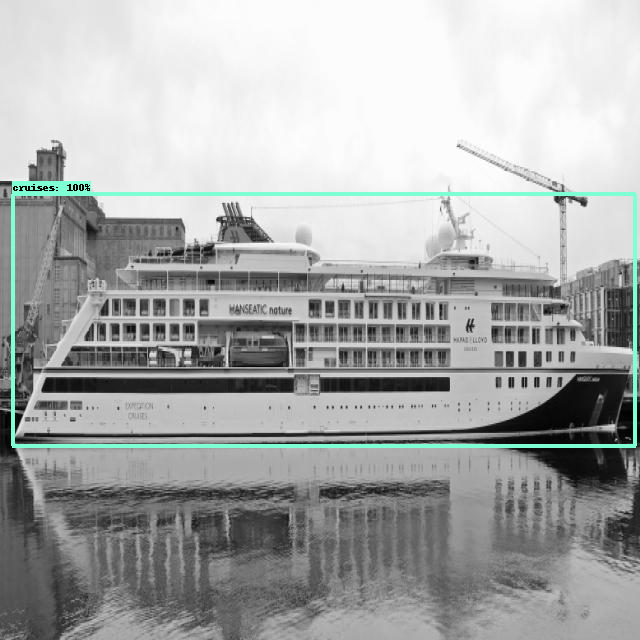

In [ ]:
image = load_image_from_data(train_df, index=10)
image

### **Image from Validation data:**

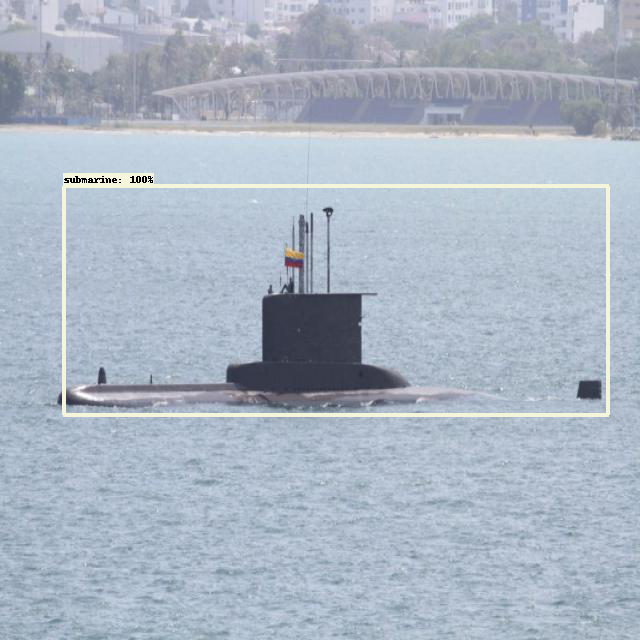

In [ ]:
image = load_image_from_data(valid_df, index=10)
image

###**Image from Test Data:**

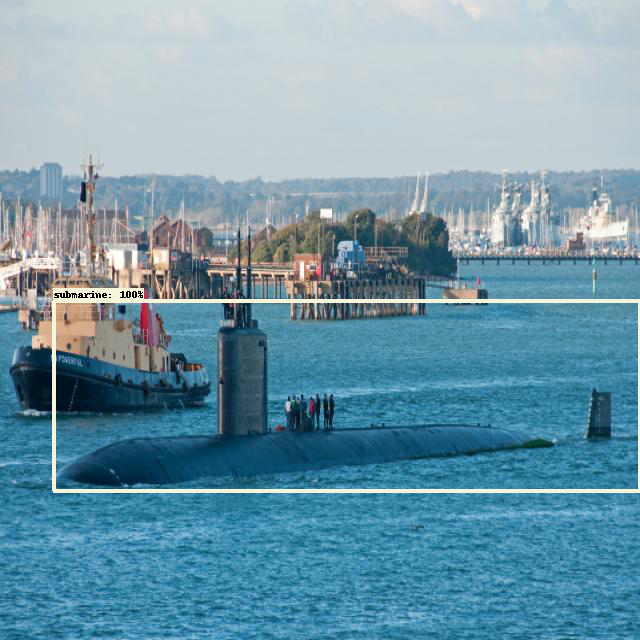

In [ ]:
image = load_image_from_data(test_df, index=5)
image

# Clearml (MLOPS)

In [ ]:
#ClearML
!pip install clearml
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=
%env CLEARML_API_SECRET_KEY=

from clearml import Task
task = Task.init(project_name="Navantia", task_name="RetinaNet_ep+lr+wd+mo2")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.7/967.7 KB 14.1 MB/s eta 0:00:00
env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=
env: CLEARML_API_SECRET_KEY=


MissingConfigError: ignored

#**Configure Custom PyTorch RetianNet Object Detection Training Configuration** :

The configuration file is present in `/content/pytorch_retinanet/hparams.yaml`.


In [ ]:
NUM_TRAIN_EPOCHS = 20

from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/Capstone_Project_G13/models/RetinaNet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV

hparams.dataloader.train_bs = 1
hparams.dataloader.valid_bs = 30
hparams.dataloader.test_bs  = 30

hparams.model.num_classes   = len(LABEL_MAP) - 1 
hparams.model.backbone_kind = "resnet50"
hparams.model.min_size      = 640
hparams.model.max_size      = 1600
hparams.model.pretrained    = True #loads in imagenet-backbone weights

#transforms for the train_dataset
hparams.transforms  =  [
    {"class_name": "albumentations.HorizontalFlip", "params": {"p": 0.5} },
    {"class_name": "albumentations.ShiftScaleRotate", "params": {"p": 0.5} },
    {"class_name": "albumentations.RandomBrightnessContrast", "params": {"p": 0.5} },
]

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD", 
    "params"    : {"lr": 0.0005, "weight_decay": 0.0005, "momentum":0.85},
    }

#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.CosineAnnealingLR", 
    "params"     : {"T_max": NUM_TRAIN_EPOCHS}, 
    "monitor"    : None, 
    "interval"   : "epoch", 
    "frequency"  : 1
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet50
  num_classes: 6
  freeze_bn: true
  min_size: 640
  max_size: 1600
  pretrained: true
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train_data.csv
  valid_paths: /content/valid_data.csv
  test_paths: /content/test_data.csv
dataloader:
  train_bs: 1
  valid_bs: 30
  test_bs: 30
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
- class_name: albumentations.ShiftScaleRotate
  params:
    p: 0.5
- class_name: albumentations.RandomBrightnessContrast
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.0005
    weight_decay: 0.0005
    momentum: 0.85
scheduler:
  class_name: torch.optim.lr_scheduler.CosineAnnealingLR
  params:
    T_max: 20
  monitor: null
  interval: epoch
  frequency: 1



#**Instantiate Lightning-Module and Lightning-Trainer**

In [ ]:
!pip install retinanet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement retinanet (from versions: none)
ERROR: No matching distribution found for retinanet


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

from Capstone_Project_G13.models.RetinaNet.model import RetinaNetModel

#from torch.hub import load_state_dict_from_url for backbone,py
#/content/pytorch_retinanet/retinanet/backbone.py

# seed so that results are reproducible
pl.seed_everything(123)

123

## **Load in the Lighning-Trainer :**

In [ ]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE: 
# For a list of whole trainer specific arguments see : 
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

lr_logger  = LearningRateMonitor(logging_interval="step")

#instantiate LightningTrainer
trainer    = Trainer(precision=16, gpus=1, callbacks=[lr_logger], max_epochs=NUM_TRAIN_EPOCHS, profiler=True, auto_lr_find=True)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.


##**Load in the Lighning-Module using the hparams file modified above & Start Train :**

In [ ]:
# Instantiate lightning-module
litModel = RetinaNetModel(conf=hparams)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2023-02-26 11:22:20,515 - clearml.model - INFO - Selected model id: 59342e1893a742d095bc884bc5d0b1e7


BACKBONE     : resnet50
INFO:retinanet.models:BACKBONE     : resnet50
INPUT_PARAMS : MAX_SIZE=1600, MIN_SIZE=640
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1600, MIN_SIZE=640
NUM_CLASSES  : 6
INFO:retinanet.models:NUM_CLASSES  : 6


In [ ]:
trainer.fit(litModel)


  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 36 M  
INFO:retinanet.models:
  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 36 M  


Validation sanity check: 0it [00:00, ?it/s]

Training: 3487it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]



Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_fit_start        	|  2.8055e-05     	|  0.00011222     
on_validation_start 	|  0.013126       	|  0.31502        
on_validation_epoch_start	|  3.3618e-05     	|  0.00080683     
on_validation_batch_start	|  3.0741e-05     	|  0.033447       
validation_step_end 	|  3.2838e-05     	|  0.035727       
on_validation_batch_end	|  0.0012619      	|  1.3729         
on_validation_epoch_end	|  4.1042e-05     	|  0.00098501     
on_validation_end   	|  2.0849         	|  50.037         
on_train_start      	|  0.018336       	|  0.073346       
on_epoch_start      	|  0.0019023      	|  0.043753       
on_train_epoch_start	|  1.837e-05      	|  0.00042251     
get_train_batch     	|  0.012134       	|  1871.9         
on_batch_start      	|  0.0018187      	|  280.59         
on_train_batch_start	|  1.6287e-05     	|  2.5126         
training_ste

1

#**Evaluating the trained-model using COCO-API Metrics** : 

In [ ]:
trainer.test(litModel)

creating index...
index created!


Testing: 0it [00:00, ?it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

[{'AP': 0.379823541420076}]

# **Export the model weights** :

In [ ]:
import torch
PATH = f"/content/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

2023-02-26 16:40:32,662 - clearml.frameworks - INFO - Found existing registered model id=f00d3731218849ba84cf1fdd76f21a11 [/content/trained_weights.pth] reusing it.


#**Load PyTorch Model from the trained Lightning-Module weights :**

In [ ]:
import logging
logger = logging.getLogger("lightning")

In [ ]:
from retinanet import Retinanet

#load saved model state dict
state_dict = torch.load(PATH)
#model arguments same as the arguments used to train the model
model_args = hparams.model
#load pytorch model without the lightning-module
#using args and state dict
MODEL      = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

BACKBONE     : resnet50
INFO:retinanet.models:BACKBONE     : resnet50
INPUT_PARAMS : MAX_SIZE=1600, MIN_SIZE=640
INFO:retinanet.models:INPUT_PARAMS : MAX_SIZE=1600, MIN_SIZE=640
NUM_CLASSES  : 6
INFO:retinanet.models:NUM_CLASSES  : 6


# **Run Inference on Test Images with Custom PyTorch Object Detector**

In [ ]:
from PIL import Image
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.

    Params
    ------
        image_path (str) : Path to the input Image
        threshold (float): Score threshold to filter predictions

    Returns
    -------
        A Dictionary contatining the predictions from generated from the model on 
        the given image. 
        Keys of the dictionary: 
          - "boxes" : bounding-box co-ordinates
          - "labels": class labels for the bounding box co-ordinates.
          - "scores": scores for the bounding box co-ordinates.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    INFER_TRANSFORMS = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True)
        ])
    
    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS  = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in 
    the given image path

    Params
    ------
        image_path `(str)` : Path to the input Image
        threshold `(float)`: Score threshold to filter predictions
    
    Returns
    -------
        boxes  `(np.array)`: filtered absolute bounding box co-ordinates.
        labels `(np.array)`: class labels for the bounding box co-ordinates.
        scores `(np.array)`: scores for the bounding box co-ordinates.
    """
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask   = scores > threshold
    boxes  = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

def draw_on_image(image_path, boxes, scores, classes, label_map=LABEL_MAP):
    """
    Draw bounding box over the image at image path, with the scores and classes
    Returns a PIL image object.
    
    Params
    ------ 
        image_path `(str)`   : Path to the input Image
        boxes `(List[N,4])`  : absolute bouding box co-ordiates in the form `[xmin,ymin,xmax,ymax]`.
        scores `(List[N])`   : List containing the scores for each of the bounding box.
        classes `(`List[N])` : List containing the class_labels for each of the bounding box.
        label_map `(List)`   : List of the labels

    Returns
    -------
        A PIL Image object
    """
    image = Image.open(image_path)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=scores, classes=classes, label_map=LABEL_MAP)
    return image

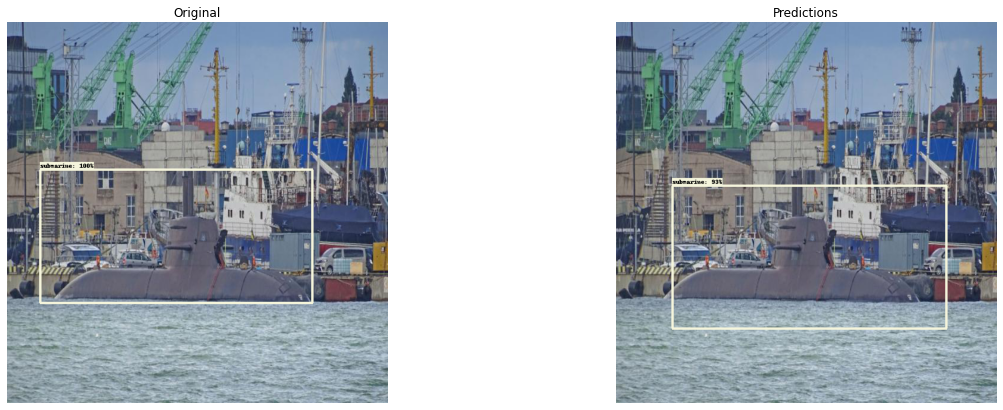

In [ ]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.60)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");

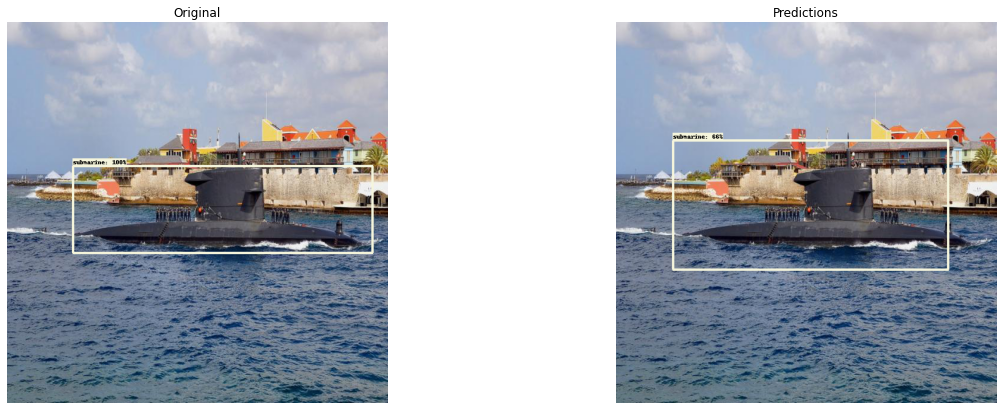

In [ ]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.60)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");

In [ ]:
!zip -r /content/lightning_logs.zip /content/lightning_logs

  adding: content/lightning_logs/ (stored 0%)
  adding: content/lightning_logs/version_0/ (stored 0%)
  adding: content/lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: content/lightning_logs/version_0/checkpoints/epoch=15.ckpt (deflated 7%)
  adding: content/lightning_logs/version_0/events.out.tfevents.1677410555.af5861a2354b.934.0 (deflated 72%)
  adding: content/lightning_logs/version_0/hparams.yaml (deflated 53%)


In [ ]:
from google.colab import files
files.download("/content/lightning_logs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>